# Fase 1 del proyecto

En esta primera fase se limpiará los datos y se elegirá una problemática para brindar solución.

## Descarga de librerias

Se descomenta el siguiente comando para ejecutar para poder instalar las dependencias.

In [18]:
# %pip install -r ../requirements.txt

## Descargar datos

Se descomenta el siguiente comando para ejecutar un script que descarga los dataset desde [Kaggle - Brazilian E-commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

In [19]:
# !python ../scripts/download_dataset.py

## Librerias utilizadas

Librerias utilizadas y globales usadas.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install plotly
import plotly.express as px
from typing import Callable, List, Tuple, Set
import os
import glob
from sklearn.preprocessing import OneHotEncoder, StandardScaler

VALOR_IMPUTADO_TEXTO = "<IMPUTADO>"

You should consider upgrading via the '/home/peanut32/.pyenv/versions/3.9.16/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Limpieza y Transformación del Dataset de Olist para Predicción Logística

Este bloque ejecutará todo el proceso de **limpieza, transformación y división del dataset de Olist**, dejando los datos listos para su uso en tareas de análisis y modelado predictivo enfocado en la dificultad logística de las entregas. Incluye la unificación de los CSV originales, la imputación de valores nulos, la validación de calidad del dataset resultante, y la separación final en archivos limpios por tabla.

Para más detall, se puede consultar la documentación de [Limpieza](../docs/limpieza.md) para saber los criterios aplicados y la documentación sobre [Variables Utilizadas](../data/variables_utilizadas.md).

In [21]:
columnas_originales = {
    'orders': [
        'order_id',
        'customer_id',
        'order_status',
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ],
    'customers': [
        'customer_id',
        'customer_unique_id',
        'customer_zip_code_prefix',
        'customer_city',
        'customer_state'
    ],
    'order_items': [
        'order_id',
        'order_item_id',
        'product_id',
        'seller_id',
        'shipping_limit_date',
        'price',
        'freight_value'
    ],
    'sellers': [
        'seller_id',
        'seller_zip_code_prefix',
        'seller_city',
        'seller_state'
    ],
    'order_reviews': [
        'review_id',
        'order_id',
        'review_score',
        'review_comment_title',
        'review_comment_message',
        'review_creation_date',
        'review_answer_timestamp'
    ],
    'order_payments': [
        'order_id',
        'payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value'
    ],
    'products': [
        'product_id',
        'product_category_name',
        'product_name_lenght',
        'product_description_lenght',
        'product_photos_qty',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm'
    ],
    'product_category_name_translation': [
        'product_category_name',
        'product_category_name_english'
    ]
}

Este diccionario contiene la definición de las columnas originales que pertenecen a cada uno de los datasets individuales del proyecto Olist. Se utiliza posteriormente para separar el dataset unificado limpio en archivos CSV independientes, simulando la estructura de los archivos originales pero sin duplicados y ya procesados. Esta estrategia permite mantener la compatibilidad con el esquema original de la base de datos y facilita el análisis modular por tabla, asegurando que solo se exporten las columnas necesarias para cada archivo.

In [22]:
def unifyOlistDatasets():
  # Cargar datasets
  orders = pd.read_csv('../data/olist_orders_dataset.csv')
  customers = pd.read_csv('../data/olist_customers_dataset.csv')
  order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
  sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
  geolocation = pd.read_csv('../data/olist_geolocation_dataset.csv')
  reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
  payments = pd.read_csv('../data/olist_order_payments_dataset.csv')
  products = pd.read_csv('../data/olist_products_dataset.csv')
  category_translation = pd.read_csv('../data/product_category_name_translation.csv')
  
  # Convertir todos los ZIP codes a string de 5 dígitos
  customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str).str.zfill(5)
  sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str).str.zfill(5)
  geolocation['geolocation_zip_code_prefix'] = geolocation['geolocation_zip_code_prefix'].astype(str).str.zfill(5)


  # Paso 1: Merge orders + customers
  df = orders.merge(customers, on='customer_id', how='left')

  # Paso 2: Merge con order_items (por order_id)
  df = df.merge(order_items, on='order_id', how='left')

  # Paso 3: Merge con sellers
  df = df.merge(sellers, on='seller_id', how='left', suffixes=('', '_seller'))

  # Paso 4: Merge con reviews
  df = df.merge(reviews, on='order_id', how='left')

  # Paso 5: Merge con payments
  df = df.merge(payments, on='order_id', how='left')

  # Paso 6: Merge con products
  df = df.merge(products, on='product_id', how='left')

  # Paso 7: Merge con traducción de categorías
  df = df.merge(category_translation, on='product_category_name', how='left')

  # Guardar dataset unificado
  outputPath = "../data/olist_dataset_unificado.csv"
  os.makedirs(os.path.dirname(outputPath), exist_ok=True)
  df.to_csv(outputPath, index=False)

  print(f"Dataset unificado generado y guardado en: {outputPath}")
  return df

Esta función realiza la unificación de todos los archivos del dataset de Olist en un único DataFrame combinando la información a través de múltiples `merge`. Se parte del archivo principal de órdenes y se van agregando datos de clientes, productos, vendedores, pagos, reseñas y localización. Para el componente geográfico (clientes y vendedores), se usan las coordenadas promedio por código postal (ZIP) extraídas del dataset de geolocalización. Esto permite integrar latitud y longitud de cada punto aunque no haya una coincidencia directa por nombre de ciudad. Finalmente, se guarda el DataFrame resultante como `olist_dataset_unificado.csv`, el cual servirá como base para los pasos posteriores de limpieza, análisis y modelado.

In [23]:
def generateDataInfoReport(df, fileName="data_quality_report.txt"):
  nullCounts = df.isnull().sum()
  totalNulls = nullCounts[nullCounts > 0]
  totalNullValues = nullCounts.sum()
  rowsWithNulls = df.isnull().any(axis=1).sum()
  duplicateCount = df.duplicated().sum()

  lines = []
  lines.append("=======================================\n")
  lines.append(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
  lines.append("=======================================\n")
  lines.append("Dataset preview (first 5 rows):")
  lines.append(df.head().to_string(index=False))
  lines.append("\n=======================================\n")

  lines.append("Null values by column:")
  if totalNulls.empty:
    lines.append("  None")
    lines.append("\n=======================================\n")
  else:
    for col, count in totalNulls.items():
      lines.append(f"  {col}: {count}")
    lines.append("\n=======================================\n")

    # Agregar ejemplos de filas con nulos
    lines.append("Examples of rows with nulls per column:\n")
    for col in totalNulls.index:
      example_row = df[df[col].isnull()].head(1)
      lines.append(f"Column: {col}")
      lines.append(example_row.to_string(index=False))
      lines.append("")  # línea vacía para separar
    lines.append("=======================================\n")

  lines.append(f"Total null values: {totalNullValues}")
  lines.append(f"Rows with at least one null value: {rowsWithNulls}")
  lines.append(f"Total duplicated rows: {duplicateCount}")
  lines.append("\n=======================================\n")

  lines.append("Columns in the dataset:")
  for col in df.columns:
    lines.append(f"    {col}")
  lines.append("\n=======================================\n")

  outputPath = os.path.join("..", "data", fileName)
  os.makedirs(os.path.dirname(outputPath), exist_ok=True)

  with open(outputPath, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

  print(f"Data quality report successfully generated at: {outputPath}")

Esta función genera un informe detallado de calidad del DataFrame recibido, exportándolo como un archivo `.txt`. El reporte incluye:  
- Dimensión del dataset (filas y columnas)  
- Vista previa de las primeras filas  
- Conteo de valores nulos por columna (y total general)  
- Cantidad de filas con al menos un valor nulo  
- Número de filas duplicadas  
- Listado completo de columnas presentes en el DataFrame  

Este análisis es clave para diagnosticar la calidad de los datos antes de la limpieza o imputación, ya que permite tomar decisiones informadas sobre qué columnas deben ser corregidas, eliminadas o transformadas. Además, centraliza esta información en un archivo que puede compartirse fácilmente con el equipo.

In [24]:
generateDF = True
df = unifyOlistDatasets() if generateDF else pd.read_csv("../data/olist_dataset_unificado.csv")
generateDataInfoReport(df)

Dataset unificado generado y guardado en: ../data/olist_dataset_unificado.csv
Data quality report successfully generated at: ../data/data_quality_report.txt


Esta instrucción permite decidir si se desea **generar nuevamente el dataset unificado desde los archivos CSV originales** (`generateDF = True`) o **cargar el archivo unificado ya generado previamente** (`generateDF = False`).  
- Si `generateDF` es `True`, se ejecuta la función `unifyOlistDatasets()`, que realiza todos los `merge` entre los archivos fuente y guarda el archivo unificado.
- Si es `False`, simplemente se carga desde disco el archivo `olist_dataset_unificado.csv`, evitando reprocesar todo.  

Este enfoque es útil para ahorrar tiempo y recursos cuando ya se cuenta con el dataset unificado en disco.

In [25]:
def cleanOlistDataset(df):
  # ZIPs como strings
  for col in ['customer_zip_code_prefix', 'seller_zip_code_prefix']:
    if col in df.columns:
      df[col] = df[col].astype(str).str.zfill(5)

  # Fechas
  if 'order_approved_at' in df.columns and 'order_purchase_timestamp' in df.columns:
    df['order_approved_at'] = df['order_approved_at'].fillna(df['order_purchase_timestamp'])

  if 'order_status' in df.columns and 'order_delivered_customer_date' in df.columns:
    mask = (df['order_status'] == 'delivered') & (df['order_delivered_customer_date'].isnull())
    df.loc[mask, 'order_delivered_customer_date'] = df.loc[mask, 'order_estimated_delivery_date']

  if 'order_delivered_carrier_date' in df.columns and 'order_approved_at' in df.columns:
    df['order_delivered_carrier_date'] = df['order_delivered_carrier_date'].fillna(df['order_approved_at'])

  # Numéricos
  for col in ['freight_value', 'price', 'payment_value', 'product_weight_g', 'product_length_cm',
              'product_height_cm', 'product_width_cm', 'product_name_lenght',
              'product_description_lenght', 'product_photos_qty']:
    if col in df.columns:
      df[col] = df[col].fillna(df[col].mean())

  # Categóricos
  if 'payment_type' in df.columns:
    df['payment_type'] = df['payment_type'].fillna(df['payment_type'].mode()[0])

  if 'payment_installments' in df.columns:
    df['payment_installments'] = df['payment_installments'].fillna(1)

  for col in ['product_category_name', 'product_category_name_english']:
    if col in df.columns:
      df[col] = df[col].fillna("unknown")

  # Textos
  for col in ['review_comment_title', 'review_comment_message']:
    if col in df.columns:
      df[col] = df[col].fillna(VALOR_IMPUTADO_TEXTO)

  # Campos faltantes críticos
  df = df.dropna(subset=['seller_id', 'product_id', 'order_item_id']).copy()

  if 'shipping_limit_date' in df.columns:
    df['shipping_limit_date'] = df['shipping_limit_date'].fillna(df['order_purchase_timestamp'])

  if 'review_score' in df.columns:
    df['review_score'] = df['review_score'].fillna(df['review_score'].mode()[0])

  if 'review_id' in df.columns:
    df['review_id'] = df['review_id'].fillna("missing")

  if 'review_creation_date' in df.columns:
    df['review_creation_date'] = df['review_creation_date'].fillna(df['order_delivered_customer_date'])

  if 'review_answer_timestamp' in df.columns:
    df['review_answer_timestamp'] = df['review_answer_timestamp'].fillna(df['review_creation_date'])

  if 'payment_sequential' in df.columns:
    df['payment_sequential'] = df['payment_sequential'].fillna(1)

  df = df.dropna(subset=['order_delivered_customer_date']).copy()

  # Guardar
  path = "../data_clean/olist_dataset_unificado_clean.csv"
  os.makedirs(os.path.dirname(path), exist_ok=True)
  df.to_csv(path, index=False)
  print(f"Clean dataset saved to: {path}")

  return df


Esta función realiza el proceso completo de limpieza e imputación del dataset unificado. Aplica técnicas de imputación basadas en el contexto de cada campo:

- Las **coordenadas geográficas** de clientes y vendedores se completan calculando promedios por código postal (ZIP).
- Las **fechas clave** como `order_approved_at`, `order_delivered_customer_date` y `order_delivered_carrier_date` se imputan de forma lógica basándose en otras columnas temporales relacionadas.
- Los **valores numéricos** como precios, peso o medidas se imputan con la media global.
- Los **campos categóricos** como tipo de pago y categoría del producto se imputan con la moda o con valores por defecto como `"unknown"`.
- Los **campos de texto** en las reseñas se rellenan con cadenas vacías.
- Se eliminan filas sin identificadores esenciales (`seller_id`, `product_id`, `order_item_id`) y aquellas sin fecha de entrega, ya que no podrían usarse para modelar el problema logístico.
- Finalmente, se eliminan columnas auxiliares de geolocalización y se guarda el dataset limpio como `olist_dataset_unificado_clean.csv`.

Esta función garantiza que el dataset esté listo para análisis y modelado sin valores nulos críticos ni inconsistencias estructurales.

In [26]:
generateDFClean = True
df_clean = cleanOlistDataset(df) if generateDFClean else pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv")
generateDataInfoReport(df=df_clean, fileName="../data_clean/data_quality_report_imputed.txt")

Clean dataset saved to: ../data_clean/olist_dataset_unificado_clean.csv
Data quality report successfully generated at: ../data/../data_clean/data_quality_report_imputed.txt


Este bloque permite decidir si se debe **generar nuevamente el dataset limpio** a partir del unificado (`generateDFClean = True`) o simplemente **cargarlo desde disco** si ya fue generado anteriormente (`False`).  
- Si es `True`, se ejecuta la función `cleanOlistDataset(df)`, que realiza todo el proceso de limpieza e imputación y guarda el nuevo archivo limpio.
- Luego, se genera un **informe de calidad actualizado** (`data_quality_report_imputed.txt`) para verificar el estado del dataset después de la limpieza, incluyendo dimensiones, nulos restantes, duplicados y vista previa.

Este paso asegura que el dataset esté limpio y que exista una documentación clara del estado posterior a la transformación.

In [27]:
def splitUnificado(df, columnas_por_tabla, output_dir="../data_clean/"):
  os.makedirs(output_dir, exist_ok=True)
  for nombre, columnas in columnas_por_tabla.items():
    columnas_presentes = [col for col in columnas if col in df.columns]
    df_filtrado = df[columnas_presentes].drop_duplicates()
    output_path = os.path.join(output_dir, f"olist_{nombre}_dataset_clean.csv")
    df_filtrado.to_csv(output_path, index=False)
    print(f"Archivo generado: {output_path}")

Esta función divide el dataset unificado limpio en múltiples archivos CSV individuales, replicando la estructura de los datasets originales.  
- Para cada grupo de columnas definido en `columnas_por_tabla`, se extraen las columnas presentes en el DataFrame unificado (`df`), eliminando duplicados.
- Cada subconjunto se guarda como un nuevo archivo `.csv` con el nombre correspondiente en la carpeta `../data_clean/`.

Esto permite trabajar con datasets separados y coherentes con los originales, pero ahora con valores imputados y limpios, facilitando análisis específicos por tabla o módulo.

In [28]:
def procesarGeolocation(
  input_path="../data/olist_geolocation_dataset.csv",
  output_path="../data_clean/olist_geolocation_dataset_clean.csv",
  generateReport=True
):

  df_geo = pd.read_csv(input_path)
  if generateReport:
    generateDataInfoReport(df=df_geo, fileName=os.path.join("../data", "geo_data_quality_before_geolocation.txt"))
  # Eliminar duplicados (no se eliminan nulos porque no hay)
  df_geo_clean = df_geo.drop_duplicates().copy()
  if generateReport:
    generateDataInfoReport(df=df_geo_clean, fileName=os.path.join("../data_clean", "geo_data_quality_after_geolocation.txt"))
  df_geo_clean.to_csv(output_path, index=False)
  print(f"Archivo generado: {output_path}")

In [29]:
splitUnificado(df_clean, columnas_originales)
procesarGeolocation(generateReport=True)

Archivo generado: ../data_clean/olist_orders_dataset_clean.csv
Archivo generado: ../data_clean/olist_customers_dataset_clean.csv
Archivo generado: ../data_clean/olist_order_items_dataset_clean.csv
Archivo generado: ../data_clean/olist_sellers_dataset_clean.csv
Archivo generado: ../data_clean/olist_order_reviews_dataset_clean.csv
Archivo generado: ../data_clean/olist_order_payments_dataset_clean.csv
Archivo generado: ../data_clean/olist_products_dataset_clean.csv
Archivo generado: ../data_clean/olist_product_category_name_translation_dataset_clean.csv
Data quality report successfully generated at: ../data/../data/geo_data_quality_before_geolocation.txt
Data quality report successfully generated at: ../data/../data_clean/geo_data_quality_after_geolocation.txt
Archivo generado: ../data_clean/olist_geolocation_dataset_clean.csv


## Exploración de datos

En esta sección se implementa un conjunto de funciones que permiten automatizar el análisis exploratorio de datos (EDA) sobre cada archivo CSV del proyecto. Estas funciones generan reportes en texto plano que incluyen información sobre valores nulos, tipos de datos, estadísticas descriptivas, valores únicos y frecuencias más comunes, lo cual facilita la comprensión individual de cada dataset y sirve como insumo para futuras decisiones de limpieza, imputación o transformación.

Para más detalle, se puede consultar la documentación sobre [Generación de Reportes](../docs/generacion_reportes.md)

In [30]:
# these functions will help with the data analysis 
# there's chance to add more information if deemeded necessary
def get_null_count(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Gives a count of nulls per column and its relative percentage.
    It does not change or replace nulls.
    params: 
        df: dataframe to get null info of
    returns:
        summary: dataframe that has a null count per col and a relative % of nulls in that col
    '''
    nulls: pd.Series = df.isnull().sum() # get the count of nulls per col
    percent: pd.Series = (nulls / len(df)) * 100 # get the percentage of nulls 
    summary: pd.DataFrame = pd.DataFrame({
        "Nulls" : nulls,
        "Percentage" : percent.round(2)
    })
    return summary[summary['Nulls'] > 0].sort_values(by='Nulls', ascending=False) # sort values by Nulls col , can change ascending to true

def get_types(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Gives the datatypes found within a dataframe.
    It does not change datatypes.
    params: 
        df: dataframe to get types of
    returns:
        types: dataframe with the type of each column
    '''
    types: pd.DataFrame = pd.DataFrame({
        'col_name' : df.columns,
        'data_type' : df.dtypes.astype(str).values
    })
    return types

def get_row_and_col_count(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Gives the number of rows and columns found in a dataframe
    params:
        df: dataframe to get num of cols and rows
    returns:
        num_row_col: dataframe with the number of columns and rows
    '''
    num_row_col: pd.DataFrame = pd.DataFrame([{
        'num_cols': len(df.columns),
        'num_rows': len(df)
    }])
    return num_row_col

def get_descriptive_stats(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Gives a brief description of the dataframe
    '''
    return df.describe().transpose()

def get_unique(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Return unique values found in the dataframe
    params:
        df: dataframe to get unique values from
    return:
        dataframe with unique values
    '''
    return df.nunique().to_frame(name='Unique Values')

def get_top_frequent(df: pd.DataFrame, top_n: int = 3) -> pd.DataFrame:
    '''
    Returns top 10 most frequent values found in the dataframe
    params: 
        df: dataframe to get unique values
        top_n: top number of values to get
    '''
    rows:list = []
    for col in df.select_dtypes(include='object').columns:
        top_vals = df[col].value_counts().head(top_n) # get the top 3 values
        for val, freq in top_vals.items(): # from those values, get the top value and its frequency
            rows.append({
                'Column Name': col,
                'Top Value': str(val), 
                'Frequency': freq
            })
    return pd.DataFrame(rows)

def write_report(df: pd.DataFrame, df_name: str, path: str, summary_functions: List[Callable]) -> None:
    '''
    Method that writes a report into a .txt of a certain dataframe
    params: 
        df: dataframe to be read
        path: where the .txt log will be saved
        summary_functions: a list functions that will be run and its returns be saved into the report
    returns:
        None
    '''
    if summary_functions is None:
        print("Please provide functions to be able to write a summary")
    
    with open(path, 'w') as log:
        log.write(f"DataFrame Summary Report Of {df_name}\n") # write header
        log.write("=" * 80 + "\n\n") 

        # for each function in the summary_functions list, write its summary and results
        for func in summary_functions:
            section_title: str = func.__name__.replace('_', ' ').title() # get the function name as title
            log.write(f"{section_title}\n")
            log.write("-" * len(section_title) + "\n")
            result_df: pd.DataFrame = func(df) # pass the dataframe argument to the function
            if result_df.empty:
                log.write("No information to report\n\n")
            else:
                log.write(result_df.to_string(index=True))
                log.write("\n\n")
        
        log.write("=" * 80 + "\nEnd\n") # finish the report


def generate_report_folder(csv_folder: str, report_folder: str, summary_functions: List[Callable]) -> None:
    '''
    Generates a report folder based upon the functions
    params:
        csv_folder: where the csv files are 
        report_folder: final folder where reports will be stored
        summary_functions: functions' returns that will be stored in the report
    '''
    os.makedirs(report_folder, exist_ok=True) # create folder if it does not exist
    csv_files: list = glob.glob(os.path.join(csv_folder, '*.csv'))
    for csv_path in csv_files:
        try:
            df: pd.DataFrame = pd.read_csv(csv_path)
            file_name: str = os.path.splitext(os.path.basename(csv_path))[0]
            report_path: str = os.path.join(report_folder, f"{file_name}_raw_report.txt")
            write_report(df=df, df_name=file_name, path=report_path, summary_functions=summary_functions)
            print(f"Report written into: {report_path}")
        except Exception as e:
            print(f"Failed processing {csv_path}: {e}")

In [31]:
# these reports are only based on each individual .csv, not on the database as a whole
generate_report_folder(csv_folder="../data_clean", report_folder="../dataset_reports_raw", summary_functions=[get_null_count, get_types, get_row_and_col_count, get_descriptive_stats, 
                                                                                                           get_top_frequent, get_unique])

Report written into: ../dataset_reports_raw/olist_products_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_product_category_name_translation_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_order_payments_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_order_items_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_sellers_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_orders_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_dataset_unificado_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_order_reviews_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_geolocation_dataset_clean_raw_report.txt
Report written into: ../dataset_reports_raw/olist_customers_dataset_clean_raw_report.txt


## Proceso de logística

Este módulo se encarga de cargar los archivos ya limpios desde la carpeta `data_clean/`, generar variables derivadas clave como el **retraso de entrega**, el **tiempo total de entrega**, y la **dificultad logística**, además de realizar la unión de datasets relevantes como `orders`, `customers`, `reviews`, `products` y `payments`. Finalmente, aplica transformaciones necesarias como codificación categórica y escalado de variables numéricas, dejando el dataset listo para entrenar modelos de clasificación.

In [32]:
orders = pd.read_csv("../data_clean/olist_orders_dataset_clean.csv", parse_dates=[
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date"
])
customers = pd.read_csv("../data_clean/olist_customers_dataset_clean.csv")
order_items = pd.read_csv("../data_clean/olist_order_items_dataset_clean.csv")
reviews = pd.read_csv(
    "../data_clean/olist_order_reviews_dataset_clean.csv",
    parse_dates=["review_creation_date", "review_answer_timestamp"]
)
products = pd.read_csv("../data_clean/olist_products_dataset_clean.csv")
payments = pd.read_csv("../data_clean/olist_order_payments_dataset_clean.csv")


Se crea la variable target dificultad logística para poder clasificar el tretraso en tres niveles: fácil, moderada y difícil. Esto permite un mejor manejo de los datos.

In [33]:
# A. Variable objetivo: dificultad logística
orders['delivery_delay'] = (
    orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
).dt.days
orders['dificultad_logistica'] = pd.cut(
    orders['delivery_delay'],
    bins=[-np.inf, 0, 5, np.inf],
    labels=["fácil", "moderada", "difícil"]
)

orders['delivery_time'] = (
    orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
).dt.days

# B. Reseñas enriquecidas
reviews['has_title'] = (reviews['review_comment_title'] != VALOR_IMPUTADO_TEXTO).astype(int)
reviews['has_message'] = (reviews['review_comment_message'] != VALOR_IMPUTADO_TEXTO).astype(int)


### Unificación de datasets

Se utilizacon las llaves para realizar los joins entre orders, reviews, order_items, etc. Esto con el objetivo de que cada fila del dataset contenga toda la información relevante para poder predecir la dificultad de la entrega.

In [34]:
# Merge orders + customers
df = orders.merge(customers, on='customer_id', how='left')

# Merge reviews simplificado
reviews_reduced = reviews[['order_id', 'review_score', 'has_title', 'has_message']]
df = df.merge(reviews_reduced, on='order_id', how='left')

# Merge order_items
df = df.merge(order_items[['order_id', 'product_id', 'freight_value', 'price']], on='order_id', how='left')

# Merge products
df = df.merge(products, on='product_id', how='left')

# Merge payment type
payment_summary = payments.groupby("order_id").agg({
    "payment_type": lambda x: x.mode()[0] if not x.mode().empty else "unknown"
}).reset_index()
df = df.merge(payment_summary, on="order_id", how="left")


### Codificación

Se aplica One-Hot Encoding a variables categóricas como product_category_name y customer_state para convertir el texto a formato numérico. Las variables numéricas como freight_value y price se escalaron con StandarScaler para evitar la influencia de las diferencias de escala.

In [35]:
df['payment_type'] = df['payment_type'].fillna('unknown')
df['product_category_name'] = df['product_category_name'].astype(str)

categorical_cols = ['customer_state', 'product_category_name']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numerical_cols = ['freight_value', 'price', 'product_weight_g', 'delivery_time']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Separación entre variables predictorias y variable objetivo, eliminando nulos y columnas irrelevantes.

In [36]:
df = df[df['dificultad_logistica'].notnull()]

X = df.drop(columns=['dificultad_logistica', 'order_id', 'customer_id', 'product_id'])
y = df['dificultad_logistica']

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,dificultad_logistica,...,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_unknown,product_category_name_utilidades_domesticas
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,-8,fácil,...,False,False,False,False,False,False,False,False,False,True
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,-6,fácil,...,False,False,False,False,False,False,False,False,False,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,-18,fácil,...,False,False,False,False,False,False,False,False,False,False
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,-13,fácil,...,False,False,False,False,False,False,False,False,False,False
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,-10,fácil,...,False,False,False,False,False,False,False,False,False,False


## Visualizando patrones básicos


In [37]:
customers = pd.read_csv("../data_clean/olist_customers_dataset_clean.csv")
geolocation = pd.read_csv("../data_clean/olist_geolocation_dataset_clean.csv")
orders = pd.read_csv("../data_clean/olist_orders_dataset_clean.csv")
order_items = pd.read_csv("../data_clean/olist_order_items_dataset_clean.csv")
order_payments = pd.read_csv("../data_clean/olist_order_payments_dataset_clean.csv")
order_reviews = pd.read_csv("../data_clean/olist_order_reviews_dataset_clean.csv")
sellers = pd.read_csv("../data_clean/olist_sellers_dataset_clean.csv")
products = pd.read_csv("../data_clean/olist_products_dataset_clean.csv")
category_translation = pd.read_csv("../data_clean/olist_product_category_name_translation_dataset_clean.csv")

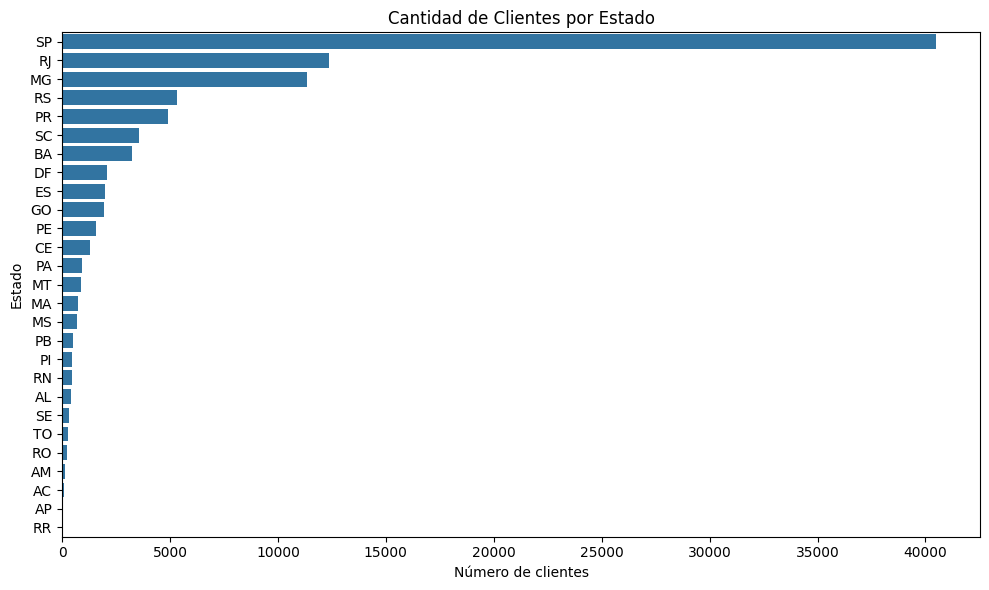

In [38]:
# 1. Clientes por estado
plt.figure(figsize=(10,6))
sns.countplot(y='customer_state', data=customers, order=customers['customer_state'].value_counts().index)
plt.title("Cantidad de Clientes por Estado")
plt.xlabel("Número de clientes")
plt.ylabel("Estado")
plt.tight_layout()
plt.show()

In [39]:
# Reducir geolocation a un punto promedio por zip code
geo_filtered = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

# Hacer merge con customers usando el ZIP prefix
geo_orders = customers.merge(geo_filtered, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

# Agrupar por ubicación geográfica
geo_summary = geo_orders.groupby(['geolocation_lat', 'geolocation_lng']).size().reset_index(name='count')

# Graficar mapa con zoom a Brasil
fig = px.scatter_geo(
    geo_summary,
    lat='geolocation_lat',
    lon='geolocation_lng',
    size='count',
    title='Concentración de Pedidos por Ubicación (Brasil)',
    projection='natural earth'
)

# Limitar vista a Sudamérica o Brasil
fig.update_geos(
    lataxis_range=[-35, 5],   # latitud aproximada de Brasil
    lonaxis_range=[-75, -30], # longitud aproximada de Brasil
    showcountries=True,
    countrycolor="LightGray"
)

fig.update_layout(
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

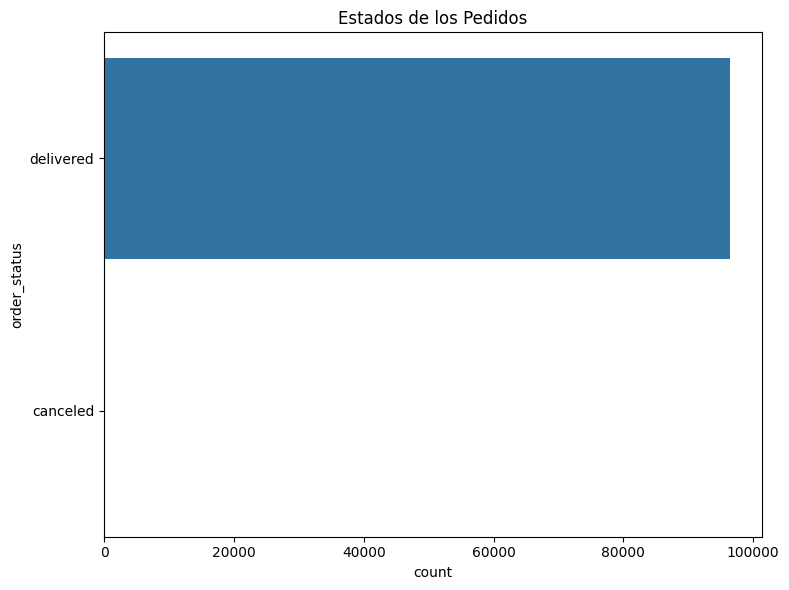

In [ ]:
# 3. Distribución de estados de pedidos
plt.figure(figsize=(8,6))
sns.countplot(y='order_status', data=orders, order=orders['order_status'].value_counts().index)
plt.title("Estados de los Pedidos")
plt.tight_layout()
plt.show()

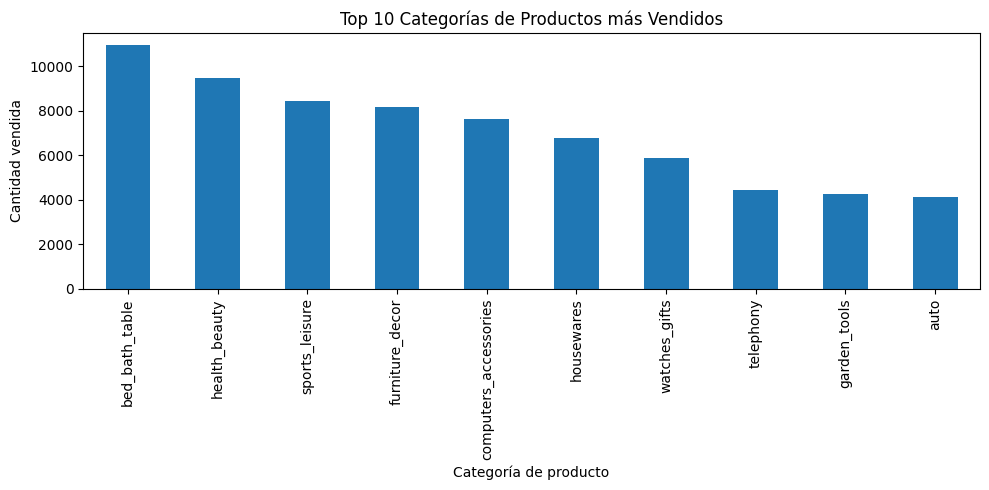

In [ ]:
# 4. Top 10 categorías de productos más vendidos (con nombre)
order_items_with_cat = order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
order_items_with_cat = order_items_with_cat.merge(category_translation, on='product_category_name', how='left')

top_categories = order_items_with_cat['product_category_name_english'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_categories.plot(kind='bar')
plt.title("Top 10 Categorías de Productos más Vendidos")
plt.xlabel("Categoría de producto")
plt.ylabel("Cantidad vendida")
plt.tight_layout()
plt.show()


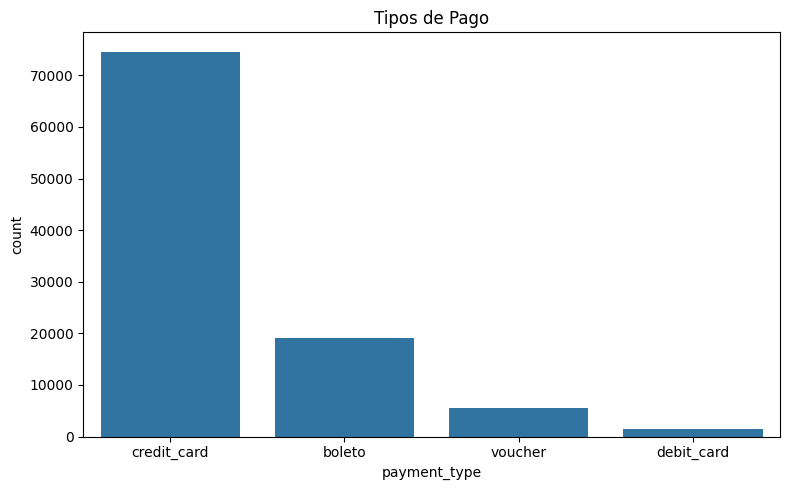

In [ ]:
# 5. Distribución de tipos de pago
plt.figure(figsize=(8,5))
sns.countplot(x='payment_type', data=order_payments, order=order_payments['payment_type'].value_counts().index)
plt.title("Tipos de Pago")
plt.tight_layout()
plt.show()

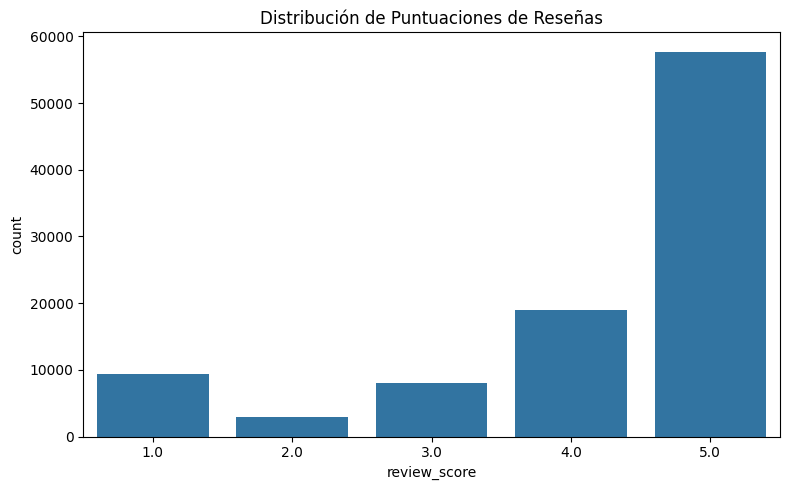

In [ ]:
# 6. Puntuación de reseñas
plt.figure(figsize=(8,5))
sns.countplot(x='review_score', data=order_reviews)
plt.title("Distribución de Puntuaciones de Reseñas")
plt.tight_layout()
plt.show()

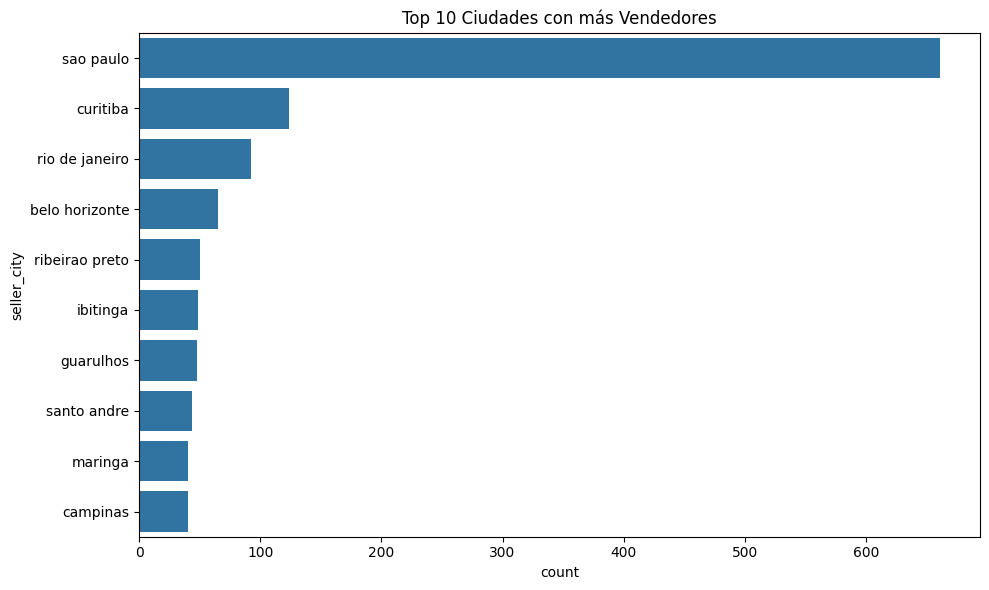

In [ ]:
# 7. Vendedores por ciudad
plt.figure(figsize=(10,6))
sns.countplot(y='seller_city', data=sellers, order=sellers['seller_city'].value_counts().head(10).index)
plt.title("Top 10 Ciudades con más Vendedores")
plt.tight_layout()
plt.show()

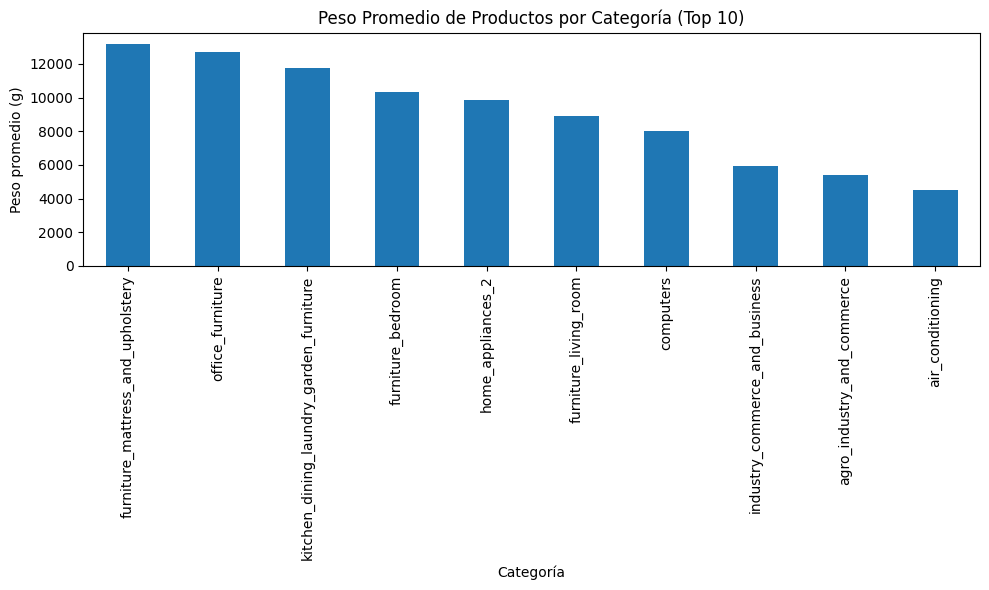

In [ ]:
# 8. Peso promedio por categoría de producto
prod_cat = products.merge(category_translation, on='product_category_name', how='left')
peso_promedio = prod_cat.groupby('product_category_name_english')['product_weight_g'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
peso_promedio.plot(kind='bar')
plt.title("Peso Promedio de Productos por Categoría (Top 10)")
plt.xlabel("Categoría")
plt.ylabel("Peso promedio (g)")
plt.tight_layout()
plt.show()

### Análisis de Correlación de Características

In [ ]:
data = pd.read_csv("../data_clean/olist_dataset_unificado_clean.csv")

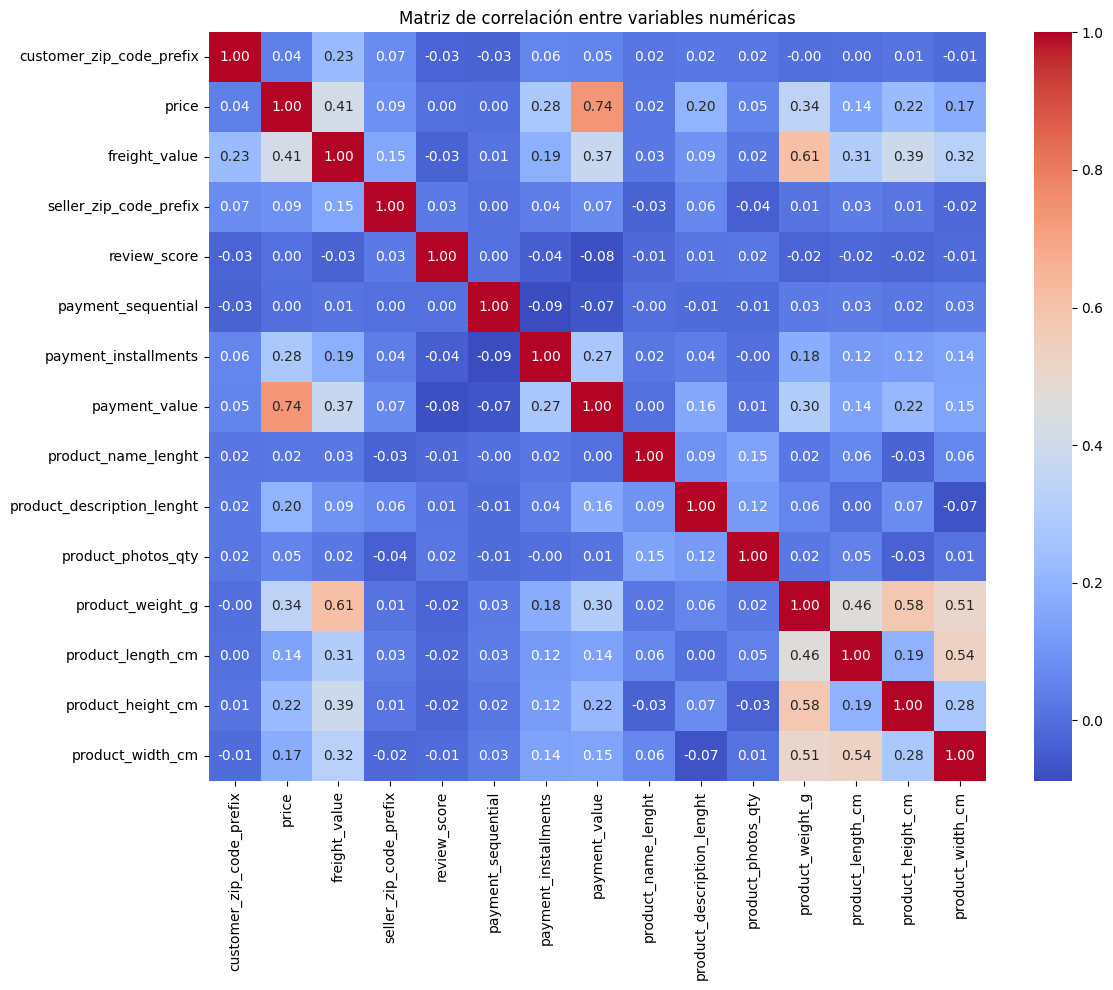

In [ ]:
plt.figure(figsize=(12, 10))
numeric_cols = data.select_dtypes(include=['float64', 'int64']).drop(columns=["order_item_id"])
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

In [ ]:
def diferenciaEntregas(data):
  # Conversión de fechas si no están en formato datetime
  if not pd.api.types.is_datetime64_any_dtype(data['order_estimated_delivery_date']):
    data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

  if not pd.api.types.is_datetime64_any_dtype(data['order_delivered_customer_date']):
    data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

  # Calcular la diferencia en días
  data['delivery_diff_days'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

  # Graficar histograma
  plt.figure()
  sns.histplot(data['delivery_diff_days'], bins=50, kde=True)
  plt.title("Diferencia entre entrega real y estimada (días)")
  plt.xlabel("Días de diferencia (positivos = retrasos)")
  plt.ylabel("Número de pedidos")
  plt.tight_layout()
  plt.show()

  return data

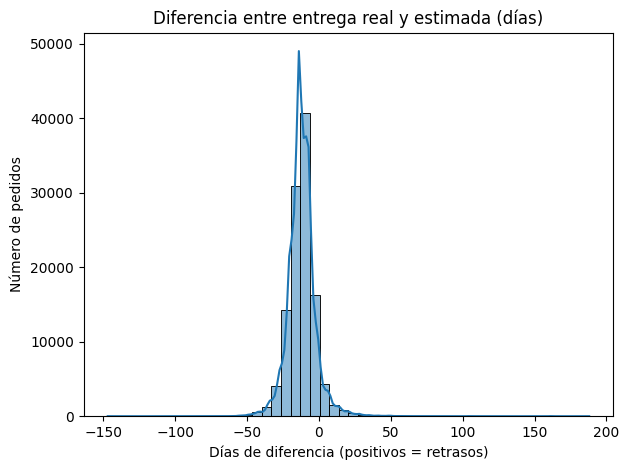

In [ ]:
data = diferenciaEntregas(data)

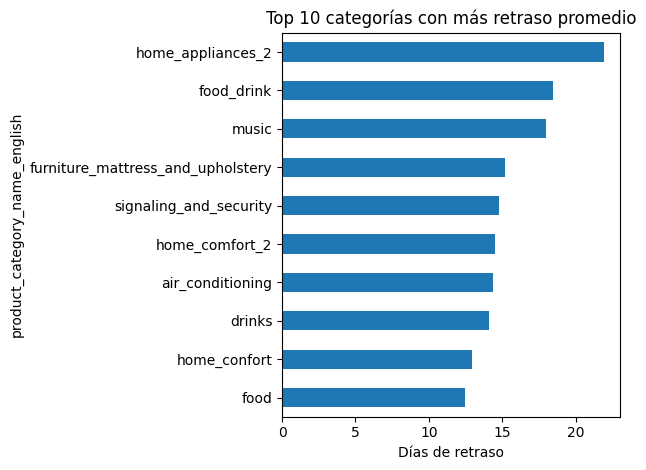

In [ ]:
def retrasoCategoriaPromedio(filepath="../data_clean/olist_dataset_unificado_clean.csv", output_txt="result_debug.txt", top_n=10):
  # Cargar datos
  data = pd.read_csv(filepath)
  data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
  data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

  # Calcular la diferencia de días
  data['delivery_diff_days'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

  # Filtrar solo retrasos
  retrasos = data[data['delivery_diff_days'] > 0]

  # Calcular promedio por categoría
  retraso_categoria = (
    retrasos.groupby('product_category_name_english')['delivery_diff_days']
    .mean()
    .sort_values(ascending=False)
  )

  # # Guardar en archivo
  # with open(output_txt, "w", encoding="utf-8") as f:
  #   f.write(f"Top {top_n} categorías con más retraso promedio (días):\n")
  #   f.write(retraso_categoria.head(top_n).to_string())

  plt.figure()
  retraso_categoria.head(top_n).sort_values(ascending=True).plot(kind='barh')
  plt.title(f"Top {top_n} categorías con más retraso promedio")
  plt.xlabel("Días de retraso")
  plt.tight_layout()
  plt.show()

retrasoCategoriaPromedio()


Top productos con más retraso individual por categoría:
       product_category_name_english  delivery_diff_days  \
64645                     cool_stuff                 188   
22791                           auto                 181   
13207              home_construction                 175   
94509                furniture_decor                 167   
103544           musical_instruments                 166   
71514                 consoles_games                 165   
79835              home_appliances_2                 162   
47571                     housewares                 161   
44844                  watches_gifts                 161   
86082          computers_accessories                 155   

                                order_id  
64645   1b3190b2dfa9d789e1f14c05b647a14a  
22791   ca07593549f1816d26a572e06dc1eab6  
13207   47b40429ed8cce3aee9199792275433f  
94509   2fe324febf907e3ea3f2aa9650869fa5  
103544  285ab9426d6982034523a855f55a885e  
71514   440d0d17af552815d

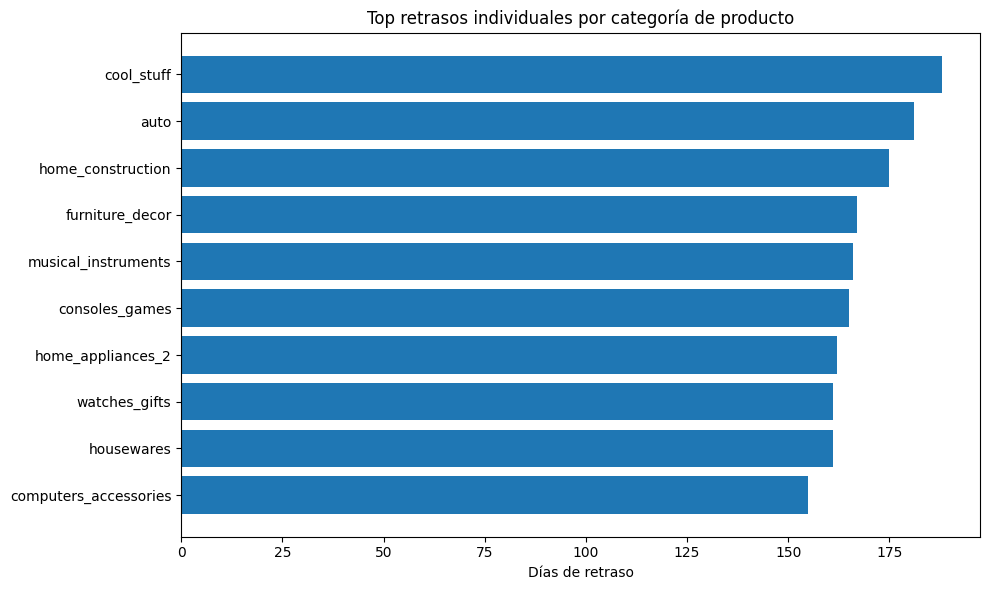

In [ ]:
def topMaxRetrasoCategoria(data, top_n=10, output_file="result_top_retrasos_sin_promedio.txt"):
  # Asegurarse de que la columna de diferencia exista
  if 'delivery_diff_days' not in data.columns:
    data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])
    data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])
    data['delivery_diff_days'] = (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days

  # Filtrar solo pedidos con retraso
  retrasos = data[data['delivery_diff_days'] > 0]

  # Obtener la fila con mayor retraso por cada categoría
  top_retrasos = (
    retrasos.sort_values(by='delivery_diff_days', ascending=False)
    .drop_duplicates(subset=['product_category_name_english'])
    .head(top_n)
  )

  # # Guardar resultados
  # top_retrasos.to_string(open(output_file, "w"))

  # Mostrar por consola las columnas más importantes
  print("Top productos con más retraso individual por categoría:")
  print(top_retrasos[['product_category_name_english', 'delivery_diff_days', 'order_id']])

  # Graficar
  plt.figure(figsize=(10, 6))
  top_retrasos_sorted = top_retrasos.sort_values(by='delivery_diff_days')
  plt.barh(
    top_retrasos_sorted['product_category_name_english'],
    top_retrasos_sorted['delivery_diff_days']
  )
  plt.xlabel("Días de retraso")
  plt.title("Top retrasos individuales por categoría de producto")
  plt.tight_layout()
  plt.show()

  return top_retrasos

top_retrasos = topMaxRetrasoCategoria(data)